# Simple example of a Bayesian neural net

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import time

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

Define the dataset and neural network

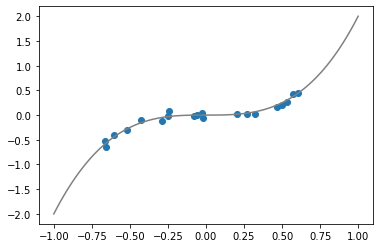

In [2]:
# Data settings
var_n = 0.05 ** 2
f = lambda x, noisy: 2 * x ** 3 + noisy*np.sqrt(var_n)*np.random.normal(size=x.shape)
n_data = 20
data_x = np.array([-0.02519606, -0.29152739, -0.60474655, 0.31944225, -0.08100553, -0.24830156, 0.57461577,
               0.50232181, 0.60433894, -0.02046175, 0.53479088, -0.65367602, -0.06110107, 0.46652892,
               -0.66163461, 0.26793157, 0.20481661, -0.24144274, -0.42398829, -0.52080597]).reshape((-1, 1))
data_y = np.array([0.04928457864952569, -0.11915410490457669, -0.405097551770553, 0.029554098140267056,
               -0.013086956159543405, -0.017770100521146612, 0.42280077037504055, 0.1944984572601308,
               0.4534092801344878, -0.05744532400253988, 0.27416952296635494, -0.6450129511010473,
               -0.00434618253501617, 0.16330603887330705, -0.5274704221475347, 0.02189741180766931,
               0.012647796994763167, 0.08367359752673682, -0.10875986459325471,
               -0.2964629150726794]).reshape((-1, 1))
x_plot = np.linspace(-1, 1, 100).reshape((-1, 1))
    
fig, ax = plt.subplots()
ax.plot(x_plot, f(x_plot, 0), color='gray')
ax.scatter(data_x, data_y)
plt.show()

In [7]:
# NN setting
layers_shape = (100, )
noise_scale = 0.05    # likelihood standard deviation (aleatory uncertainty)
prior_scale = 1
    
kernels_shape = [(l1, l2) for l1, l2 in zip((1,) + layers_shape, layers_shape + (1,))]
kernels_size = [np.prod(ks) for ks in kernels_shape]
bias_shape = list(layers_shape) + [1,]
bias_size = [np.prod(bs) for bs in bias_shape]
n_weights = int(np.sum(kernels_size) + np.sum(bias_size))
print(n_weights)

301


Some functions needed later

In [4]:
def compute_predictions(x, weights):
    # weights is given as an array of shape (nchains, nweights)
    # Go through the network layers
    nchains, ndata, _ = x.shape
    nc = 0
    for ks, k, bs, b in zip(kernels_shape[:-1], kernels_size[:-1], bias_shape[:-1], bias_size[:-1]):
        # Compute W X + b for layer l
        x = tf.matmul(x, tf.reshape(weights[:, nc:nc + k], (nchains,) + ks))
        x += tf.tile(tf.expand_dims(weights[:, nc + k:nc + k + b], 1), (1, ndata, 1))
        nc += k + b
        # Apply activation function
        x = tf.nn.relu(x)
    # Compute W X + b for last layer (linear)
    ks, k, bs, b = kernels_shape[-1], kernels_size[-1], bias_shape[-1], bias_size[-1]
    x = tf.matmul(x, tf.reshape(weights[:, nc:nc + k], (nchains,) + ks)) 
    x += tf.tile(tf.expand_dims(weights[:, nc + k:nc + k + b], 1), (1, ndata, 1))
    return x

def target_log_prob_fn(weights):
    # evaluate the scaled log posterior = log likelihood + log prior
    # weights is given as an array of shape (nchains, nweights)
    nchains = weights.shape[0]
    x_true = tf.cast(tf.tile(tf.expand_dims(data_x, 0), (nchains, 1, 1)), dtype=tf.float32)
    y_true = tf.cast(tf.tile(tf.expand_dims(data_y, 0), (nchains, 1, 1)), dtype=tf.float32)
    # compute log likelihood
    y_pred = compute_predictions(x_true, weights)
    loglike = tf.reduce_sum(tfp.distributions.Normal(loc=y_true, scale=noise_scale).log_prob(y_pred), axis=(1, 2))
    # compute log prior of the weights
    logprior = tf.reduce_sum(tfp.distributions.Normal(loc=0., scale=prior_scale).log_prob(weights), axis=1)
    return loglike + logprior

def predict_from_chains(x, samples):
    # function used to compute predictions from the final weights samples
    nsamples, nchains, d = samples.shape
    n_tot = nsamples * nchains
    
    x_pred = tf.cast(tf.tile(tf.expand_dims(x, 0), (n_tot, 1, 1)), dtype=tf.float32)
    y_pred = compute_predictions(x_pred, samples.reshape((n_tot, d))).numpy()[:, :, 0]
    print(y_pred.shape)
    
    return y_pred.reshape((nsamples, nchains, x.shape[0]))

In [10]:
# HMC Settings
n_burnin = int(2e3)  # number of burn-in steps
n_jump = 10 #15
step_size = 0.002
num_leapfrog_steps = 10

# Define HMC algorithm
kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn, step_size=step_size, num_leapfrog_steps=num_leapfrog_steps)

In [11]:
nchains = 10
num_iterations = 500

current_state = tf.constant(0.1 * np.random.randn(nchains, n_weights), dtype=tf.float32)

all_states = np.empty((0, n_weights), dtype=np.float32)
all_is_accepted = np.empty((0, ), dtype=int)

# Run MCMC chains - note: this takes a while to run!
samples, is_accepted = tfp.mcmc.sample_chain(
    num_results=num_iterations, num_burnin_steps=n_burnin, num_steps_between_results=n_jump,
    kernel=kernel, current_state=current_state, trace_fn=(lambda current_state,
    kernel_results: kernel_results.is_accepted))

(5000, 50)


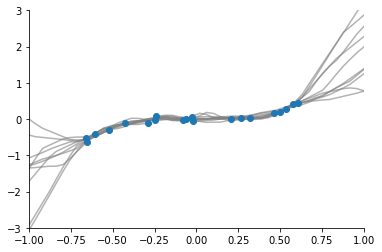

In [14]:
xx = np.linspace(-1, 1)
y_pred = predict_from_chains(xx.reshape((-1, 1)), samples.numpy())

fig, ax = plt.subplots()
for y in y_pred[-1, :, :]:
    ax.plot(xx, y, color='gray', alpha=0.6)
ax.plot(data_x, data_y, linestyle='none', marker='o')
ax.set_xlim([-1, 1])
ax.set_ylim([-3, 3])
#ax.grid(True)
for pos in ['right', 'top']: #, 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.show()

(5000, 50)


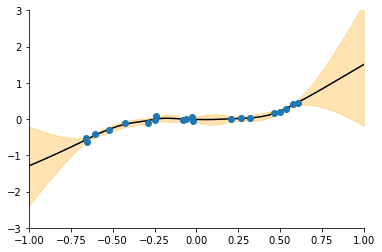

In [15]:
xx = np.linspace(-1, 1)
y_mc = predict_from_chains(xx.reshape((-1, 1)), samples.numpy()).reshape((-1, xx.size))
yy_mean, yy_std = np.mean(y_mc, axis=0).reshape((-1,)), np.std(y_mc, axis=0).reshape((-1,))

fig, ax = plt.subplots()
ax.plot(xx, yy_mean, color='black')
ax.fill_between(xx, yy_mean-2*yy_std, yy_mean+2*yy_std, color='orange', alpha=0.3)
ax.plot(data_x, data_y, linestyle='none', marker='o')
ax.set_xlim([-1, 1])
ax.set_ylim([-3, 3])
#ax.grid(True)
for pos in ['right', 'top']: #, 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.show()